# LAB: Comparación de modelos

En este lab vamos a comparar el rendimiento de todos los modelos que hemos aprendido hasta ahora, utilizando el dataset de evaluación de autos.

In [4]:
import pandas as pd

from IPython.display import Image

import pydotplus

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz

In [68]:
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [15]:
from sklearn.neighbors import KNeighborsClassifier

## 1. Preparación de los datos

El [dataset de evaluación de autos](https://archive.ics.uci.edu/ml/machine-learning-databases/car/) está en la carpeta datasets. Ya debería estar familiarizado con el mismo.

1. Leer los datos en un dataframe de pandas
- Codificar adecuadamente los features categóricos: definir un mapeo que preserve el orden (asignando números más pequeños a palabras que indiquen cantidades más pequeñas)
- Separar los features de la variable objetivo en X e y

In [6]:
df = pd.read_csv('car.csv') # Revisar el path
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:
print (df.buying.unique())
print (df.maint.unique())
print (df.lug_boot.unique())
print (df.safety.unique())
print (df.acceptability.unique())
print (df.persons.unique())
print (df.doors.unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']
['2' '4' 'more']
['2' '3' '4' '5more']


In [8]:
map1 = {'low':1,
        'med':2,
        'high':3,
        'vhigh':4}
map2 = {'small':1,
        'med':2,
        'big':3}
map3 = {'unacc':1,
        'acc':2,
        'good':3,
        'vgood':4}
map4 = {'2': 2,
        '4': 4,
        'more': 5}
map5 = {'2': 2,
        '3': 3,
        '4': 4,
        '5more': 5}

In [9]:
features = [c for c in df.columns if c != 'acceptability']
dfn = df.copy()

dfn.buying= df.buying.map(map1)
dfn.maint= df.maint.map(map1)
dfn.lug_boot = df.lug_boot.map(map2)
dfn.persons = df.persons.map(map4)
dfn.doors = df.doors.map(map5)
dfn.safety = df.safety.map(map1)
dfn.acceptability = df.acceptability.map(map3)

X = dfn[features]
y = dfn['acceptability']
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,4,4,2,2,1,1
1,4,4,2,2,1,2
2,4,4,2,2,1,3
3,4,4,2,2,2,1
4,4,4,2,2,2,2


In [10]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying           1728 non-null int64
maint            1728 non-null int64
doors            1728 non-null int64
persons          1728 non-null int64
lug_boot         1728 non-null int64
safety           1728 non-null int64
acceptability    1728 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


## 2. Preparación útil

Dado que vamos a comparar varios modelos, resulta conveniente  escribir funciones auxiliares.

1. Separar X e y entre entrenamiento / prueba, usando el 30% como set de prueba, y asignando `random_state=42`
    - Asegurar de que los datos son mezclados y estratificados
2. Definir una función llamada `evaluate_model`, que entrene el modelo con el set de entrenamiento y lo evalué con el set de prueba. Y que calcule:
    - accuracy score
    - confusion matrix
    - classification report
3. Inicializar un diccionario global para almacenar los distintos modelos, para su posterior uso.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print (cm)
    print (cr)
    
    return a

In [14]:
all_models = {}

## 3.a KNN

Comenzar con `KNeighborsClassifier`.

1. Inicializar un modelo KNN
- Evaluar su rendimiento con la función definida previamente
- Buscar el valor óptimo de K mediante Grid Search
    - Tener cuidado en cómo realizar la validación cruzada en Grid Search

In [16]:
a = evaluate_model(KNeighborsClassifier())

[[354   9   0   0]
 [  8 107   0   0]
 [  0   9  11   1]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.84      0.93      0.88       115
          3       1.00      0.52      0.69        21
          4       0.95      0.90      0.92        20

avg / total       0.95      0.94      0.94       519



In [19]:
params = {'n_neighbors': range(2,60)}
gsknn = GridSearchCV(KNeighborsClassifier(),params, n_jobs=-1,cv=KFold(n_splits=3, shuffle=True))

In [20]:
gsknn.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(2, 60)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [21]:
gsknn.best_params_

{'n_neighbors': 5}

In [22]:
gsknn.best_score_

0.95601851851851849

In [23]:
evaluate_model(gsknn.best_estimator_)

[[354   9   0   0]
 [  8 107   0   0]
 [  0   9  11   1]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.84      0.93      0.88       115
          3       1.00      0.52      0.69        21
          4       0.95      0.90      0.92        20

avg / total       0.95      0.94      0.94       519



0.94412331406551064

In [24]:
all_models['knn'] = {'model': gsknn.best_estimator_,
                     'score': gsknn.best_score_}

## 3.b Bagging + KNN

Habiendo encontrado el K óptimo, vamos a meter `KNeighborsClassifier` en un BaggingClassifier y ver si la puntuación mejora.

1. Usar el modelo KNN en un Bagging Classifier
- Evaluar el rendimiento
- Hacer un Grid Search sólo en los parámetros del Bagging Classifier

In [27]:
baggingknn = BaggingClassifier(KNeighborsClassifier())

In [28]:
evaluate_model(baggingknn)

[[358   5   0   0]
 [  8 106   1   0]
 [  0   5  15   1]
 [  0   4   0  16]]
             precision    recall  f1-score   support

          1       0.98      0.99      0.98       363
          2       0.88      0.92      0.90       115
          3       0.94      0.71      0.81        21
          4       0.94      0.80      0.86        20

avg / total       0.95      0.95      0.95       519



0.95375722543352603

In [29]:
bagging_params = {'n_estimators': [10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}

In [30]:
gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=KFold(n_splits=3, shuffle=True))

In [31]:
gsbaggingknn.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20], 'max_samples': [0.7, 1.0], 'max_features': [0.7, 1.0], 'bootstrap_features': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
gsbaggingknn.best_params_

{'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 20}

In [33]:
all_models['gsbaggingknn'] = {'model': gsbaggingknn.best_estimator_,
                              'score': evaluate_model(gsbaggingknn.best_estimator_)}

[[358   5   0   0]
 [  6 108   1   0]
 [  0   8  12   1]
 [  0   4   0  16]]
             precision    recall  f1-score   support

          1       0.98      0.99      0.98       363
          2       0.86      0.94      0.90       115
          3       0.92      0.57      0.71        21
          4       0.94      0.80      0.86        20

avg / total       0.95      0.95      0.95       519



In [34]:
all_models

{'gsbaggingknn': {'model': BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
           bootstrap=True, bootstrap_features=False, max_features=1.0,
           max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
           random_state=None, verbose=0, warm_start=False),
  'score': 0.95183044315992293},
 'knn': {'model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'), 'score': 0.95601851851851849}}

## 4. Regresión Logística

Ahora veamos si la regresión logística funciona mejor

1. Inicializar una Regresión Logística y evaluarla
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [36]:
lr = LogisticRegression()

In [37]:
all_models['lr'] = {'model': lr,
                    'score': evaluate_model(lr)}

[[347  11   4   1]
 [ 59  53   3   0]
 [  5  15   1   0]
 [  0  19   0   1]]
             precision    recall  f1-score   support

          1       0.84      0.96      0.90       363
          2       0.54      0.46      0.50       115
          3       0.12      0.05      0.07        21
          4       0.50      0.05      0.09        20

avg / total       0.73      0.77      0.74       519



In [38]:
params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
          'penalty': ['l1', 'l2']}

In [39]:
gslr = GridSearchCV(lr,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gslr.fit(X, y)

print (gslr.best_params_)
print (gslr.best_score_)

all_models['gslr'] = {'model': gslr.best_estimator_,
                             'score': evaluate_model(gslr.best_estimator_)}

{'C': 10.0, 'penalty': 'l1'}
0.829861111111
[[344  14   4   1]
 [ 48  64   3   0]
 [  4  14   2   1]
 [  0   9   0  11]]
             precision    recall  f1-score   support

          1       0.87      0.95      0.91       363
          2       0.63      0.56      0.59       115
          3       0.22      0.10      0.13        21
          4       0.85      0.55      0.67        20

avg / total       0.79      0.81      0.80       519



In [40]:
all_models

{'gsbaggingknn': {'model': BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
           bootstrap=True, bootstrap_features=False, max_features=1.0,
           max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
           random_state=None, verbose=0, warm_start=False),
  'score': 0.95183044315992293},
 'gslr': {'model': LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False), 'score': 0.81117533718689783},
 'knn': {'model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'), 'score': 0.95601851851851

In [41]:
gsbagginglr = GridSearchCV(BaggingClassifier(gslr.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbagginglr.fit(X, y)

print (gsbagginglr.best_params_)
print (gsbagginglr.best_score_)

all_models['gsbagginglr'] = {'model': gsbagginglr.best_estimator_,
                             'score': evaluate_model(gsbagginglr.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
0.829861111111
[[344  14   4   1]
 [ 51  61   3   0]
 [  3  15   2   1]
 [  0   8   0  12]]
             precision    recall  f1-score   support

          1       0.86      0.95      0.90       363
          2       0.62      0.53      0.57       115
          3       0.22      0.10      0.13        21
          4       0.86      0.60      0.71        20

avg / total       0.78      0.81      0.79       519



In [42]:
all_models

{'gsbaggingknn': {'model': BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
           bootstrap=True, bootstrap_features=False, max_features=1.0,
           max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
           random_state=None, verbose=0, warm_start=False),
  'score': 0.95183044315992293},
 'gsbagginglr': {'model': BaggingClassifier(base_estimator=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
           bootstrap=True, bootstrap_features=False, max_features=1.0,
           max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
           random_state=None, verbose=0, warm_start=False),


## 5. Árboles de decisión

Comprobemos como rinden los Árboles de Decisión

1. Inicializar un árbol de decisión y evaluarlo
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [43]:
dt = DecisionTreeClassifier()

In [44]:
all_models['dt'] = {'model': dt,
                    'score': evaluate_model(dt)}

[[360   3   0   0]
 [ 11 103   1   0]
 [  1   2  18   0]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.97      0.99      0.98       363
          2       0.94      0.90      0.92       115
          3       0.95      0.86      0.90        21
          4       1.00      0.95      0.97        20

avg / total       0.96      0.96      0.96       519



In [45]:
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsdt.fit(X, y)
print (gsdt.best_params_)
print (gsdt.best_score_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.97974537037


In [46]:
all_models['gsdt'] = {'model': gsdt.best_estimator_,
                      'score': evaluate_model(gsdt.best_estimator_)}

[[360   3   0   0]
 [ 11 103   1   0]
 [  1   2  18   0]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.97      0.99      0.98       363
          2       0.94      0.90      0.92       115
          3       0.95      0.86      0.90        21
          4       1.00      0.95      0.97        20

avg / total       0.96      0.96      0.96       519



In [47]:
gsbaggingdt = GridSearchCV(BaggingClassifier(gsdt.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbaggingdt.fit(X, y)

print (gsbaggingdt.best_params_)
print (gsbaggingdt.best_score_)

all_models['gsbaggingdt'] = {'model': gsbaggingdt.best_estimator_,
                             'score': evaluate_model(gsbaggingdt.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10}
0.97974537037
[[362   1   0   0]
 [  8 106   0   1]
 [  0   4  17   0]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      1.00      0.99       363
          2       0.94      0.92      0.93       115
          3       1.00      0.81      0.89        21
          4       0.95      0.90      0.92        20

avg / total       0.97      0.97      0.97       519



In [48]:
all_models

{'dt': {'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'), 'score': 0.96339113680154143},
 'gsbaggingdt': {'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
           bootstrap=True, bootstrap_features=False, max_features=1.0,
           max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None

## 6. Support Vector Machines

Analicemos como funciona SVM

1. Inicializar un SVM y evaluarlo
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [50]:
svm = SVC()
all_models['svm'] = {'model': svm,
                     'score': evaluate_model(svm)}

[[352  11   0   0]
 [  4 110   1   0]
 [  0   5  14   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.97      0.98       363
          2       0.87      0.96      0.91       115
          3       0.93      0.67      0.78        21
          4       0.90      0.95      0.93        20

avg / total       0.96      0.95      0.95       519



In [51]:
params = {'C': [0.01, 0.1, 1.0, 10.0, 30.0, 100.0],
          'gamma': ['auto', 0.1, 1.0, 10.0],
          'kernel': ['linear', 'rbf']}


gssvm = GridSearchCV(svm,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gssvm.fit(X, y)
print (gssvm.best_params_)
print (gssvm.best_score_)

all_models['gssvm'] = {'model': gssvm.best_estimator_,
                      'score': evaluate_model(gssvm.best_estimator_)}

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.98900462963
[[362   1   0   0]
 [  5 110   0   0]
 [  1   3  16   1]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.98      1.00      0.99       363
          2       0.96      0.96      0.96       115
          3       1.00      0.76      0.86        21
          4       0.95      0.95      0.95        20

avg / total       0.98      0.98      0.98       519



In [52]:
gsbaggingsvm = GridSearchCV(BaggingClassifier(gssvm.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbaggingsvm.fit(X, y)

print (gsbaggingsvm.best_params_)
print (gsbaggingsvm.best_score_)

all_models['gsbaggingsvm'] = {'model': gsbaggingsvm.best_estimator_,
                             'score': evaluate_model(gsbaggingsvm.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
0.978009259259
[[362   1   0   0]
 [  6 109   0   0]
 [  0   7  13   1]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      1.00      0.99       363
          2       0.92      0.95      0.93       115
          3       1.00      0.62      0.76        21
          4       0.95      0.90      0.92        20

avg / total       0.97      0.97      0.97       519



## 7. Random Forest & Extra Trees

Ahora veamos por último como funcionan Random Forest y Extra Trees

1. Inicializar RF y ET y evaluarlos
- Buscar los parámetros óptimos con Grid Search

In [54]:
rf = RandomForestClassifier()
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}

[[356   6   1   0]
 [  3 111   0   1]
 [  0   1  19   1]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.98      0.99       363
          2       0.93      0.97      0.95       115
          3       0.95      0.90      0.93        21
          4       0.90      0.95      0.93        20

avg / total       0.97      0.97      0.97       519



In [55]:
et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}

[[358   5   0   0]
 [ 12 103   0   0]
 [  0   6  14   1]
 [  0   3   0  17]]
             precision    recall  f1-score   support

          1       0.97      0.99      0.98       363
          2       0.88      0.90      0.89       115
          3       1.00      0.67      0.80        21
          4       0.94      0.85      0.89        20

avg / total       0.95      0.95      0.95       519



In [59]:
#all_models

In [58]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsrf.fit(X, y)
print (gsrf.best_params_)
print (gsrf.best_score_)

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
0.97974537037
[[358   4   1   0]
 [  7 107   0   1]
 [  1   4  14   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.98      0.99      0.98       363
          2       0.92      0.93      0.93       115
          3       0.93      0.67      0.78        21
          4       0.86      0.95      0.90        20

avg / total       0.96      0.96      0.96       519



In [60]:
gset = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gset.fit(X, y)
print (gset.best_params_)
print (gset.best_score_)

all_models['gset'] = {'model': gset.best_estimator_,
                      'score': evaluate_model(gset.best_estimator_)}

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
0.972222222222
[[359   3   1   0]
 [  3 111   0   1]
 [  0   2  17   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.99      0.99       363
          2       0.95      0.97      0.96       115
          3       0.94      0.81      0.87        21
          4       0.86      0.95      0.90        20

avg / total       0.98      0.97      0.97       519



## 8. Comparación de modelos

Vamos a comparar los resultados de los diferentes modelos.

1. Haga un gráfico de barras de los resultados de los mejores modelos. ¿Cuál es el ganador?
- Volver a evaluar todos los modelos usando una validación cruzada estratificada de 3-fold
- Hacer un gráfico de barras, mostrando el valor medio y desvío del resultado de la validación cruzada. ¿Es el mismo ganador?


In [62]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.items()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)

(0.6, 1.1)

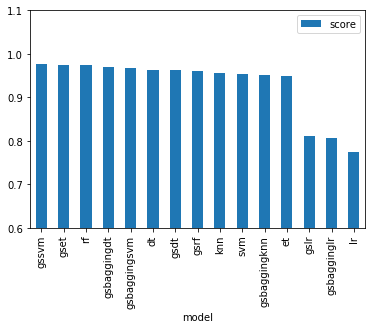

In [63]:
scores.plot(kind='bar')
plt.ylim(0.6, 1.1)

In [64]:
scores

,score
model,
gssvm,0.976879
gset,0.974952
rf,0.973025
gsbaggingdt,0.969171
gsbaggingsvm,0.967245
dt,0.963391
gsdt,0.963391
gsrf,0.959538
knn,0.956019


In [66]:
def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(n_splits=3, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.items():
    cvres = retest(v['model'])
    print (k), 
    all_models[k]['cvres'] = cvres

knn
gsbaggingknn
lr
gslr
gsbagginglr
dt
gsdt
gsbaggingdt
svm
gssvm
gsbaggingsvm
rf
et
gsrf
gset


,score,error
model,,
gssvm,0.981485,0.004968
gsrf,0.975701,0.006145
dt,0.972219,0.002492
gset,0.971640,0.007282
gsbaggingdt,0.970474,0.009866
gsdt,0.969906,0.006995
et,0.965272,0.004302
gsbaggingsvm,0.962975,0.009071
rf,0.953124,0.003762


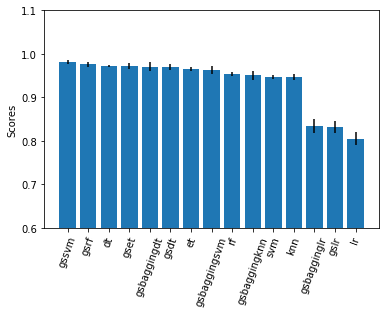

In [67]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.items()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)


fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.6, 1.1)

cvscores

## Extra

Hemos codificado los datos utilizando un mapa que preservaba el orden.
¿Cómo cambiarían los resultados si codificamos los datos categóricos utilizando `pd.get_dummies` o `OneHotEncoder` para codificarlos como variables binarias?

1. Repetir el análisis para este escenario. ¿Es mejor?
- Experimentar con otros modelos u otros parámetros, ¿puedes obtener el mejor resultado de la clase?

In [69]:
all_modelsoh={}

onehotpipe = make_pipeline(OneHotEncoder() , dt)

all_modelsoh['onehotpipe'] = {'model': onehotpipe,
                            'score': evaluate_model(onehotpipe)}

[[358   4   1   0]
 [ 18  96   1   0]
 [  0   3  16   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.95      0.99      0.97       363
          2       0.92      0.83      0.88       115
          3       0.89      0.76      0.82        21
          4       0.90      0.95      0.93        20

avg / total       0.94      0.94      0.94       519

